# Sparkify - A churn analysis by predicting model

This notebook uses a toy dataset (128MB) made by udacity to analysis churn for a supposed music app called sparkify. The dataset is a log for the events made by the users in the app.

In [130]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, DateType
from pyspark.sql.functions import count, when, col, desc, asc, from_unixtime, datediff
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, MinMaxScaler
from matplotlib import pyplot as plt

import datetime

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Predicting churn') \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1635796037238'),
 ('spark.app.name', 'Predicting churn'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '38689'),
 ('spark.driver.host', 'c7b8708c71df'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this notebook, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

# Exploratory Data Analysis

### Define Churn

Churn is defined in this case using the event “Cancellation Confirmation”. So let’s create a column to the user's ID and another to say if this user canceled the service of music streaming or not. 

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.createOrReplaceTempView('user_log_table')

In [7]:
spark.sql('''
            SELECT * 
            FROM user_log_table
            LIMIT 2
            '''
         ).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [17]:
spark.sql('''
            SELECT userID, auth, level, location, page, song, status
            FROM user_log_table
            WHERE userID = 30
            LIMIT 40
            '''
         ).toPandas()

,userID,auth,level,location,page,song,status
0,30,Logged In,paid,"Bakersfield, CA",NextSong,Rockpools,200
1,30,Logged In,paid,"Bakersfield, CA",NextSong,Time For Miracles,200
2,30,Logged In,paid,"Bakersfield, CA",NextSong,Harder Better Faster Stronger,200
3,30,Logged In,paid,"Bakersfield, CA",NextSong,Passengers (Old Album Version),200
4,30,Logged In,paid,"Bakersfield, CA",Add to Playlist,None,200
5,30,Logged In,paid,"Bakersfield, CA",NextSong,Fuck Kitty,200
6,30,Logged In,paid,"Bakersfield, CA",NextSong,Jade,200
7,30,Logged In,paid,"Bakersfield, CA",NextSong,So-Called Friends,200
8,30,Logged In,paid,"Bakersfield, CA",NextSong,Represent,200
9,30,Logged In,paid,"Bakersfield, CA",NextSong,Here I Am,200


In [11]:
# Displaying all the possible events a user could do
spark.sql('''
            SELECT DISTINCT(page)
            FROM user_log_table
            '''
         ).collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [12]:
is_churn = spark.sql('''
                    SELECT userID, SUM(isChurn) AS isChurn
                    FROM (
                        SELECT userID,
                            CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END AS isChurn
                        FROM user_log_table
                        )
                    GROUP BY 1
                ''')

In [13]:
is_churn.toPandas().head()

,userID,isChurn
0,100010,0
1,200002,0
2,125,1
3,51,1
4,124,0


### Explore Data
Let's do some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [14]:
# Total log registers
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [15]:
# Total of unique users
spark.sql('''
            SELECT COUNT(DISTINCT(userID)) 
            FROM user_log_table
            '''
         ).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   226|
+----------------------+



In [16]:
# Display all types of auth
spark.sql('''
            SELECT DISTINCT(auth) 
            FROM user_log_table
            '''
         ).show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [18]:
# Understanding the log of Guest users
spark.sql('''
            SELECT userID, auth, level, location, page, song, status
            FROM user_log_table
            WHERE auth = "Guest"
            LIMIT 20
            '''
         ).toPandas()

,userID,auth,level,location,page,song,status
0,,Guest,free,None,Error,None,404
1,,Guest,free,None,Home,None,200
2,,Guest,free,None,Register,None,200
3,,Guest,free,None,Help,None,200
4,,Guest,free,None,Home,None,200
5,,Guest,free,None,About,None,200
6,,Guest,free,None,Register,None,200
7,,Guest,free,None,Home,None,200
8,,Guest,free,None,Register,None,200
9,,Guest,free,None,Help,None,200


In [19]:
# Display all pages allowed to access by Guest users
spark.sql('''
            SELECT DISTINCT(page) 
            FROM user_log_table
            WHERE auth = "Guest"
            '''
         ).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|           Register|
|               Help|
|              Error|
+-------------------+



The userID field is empty for Guest users, and we can see that this type of user can't use the full services available. So lt's clear the data set, dropping all records without userId and sessionId, since one identifies the user and the other is used by HTTP protocol to network communications, being extremely necessary to provide services for the logged users.

In [20]:
# Total registers before cleaning
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [21]:
# Total registers after cleaning
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            WHERE userID <> '' AND sessionID IS NOT NULL
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [22]:
valid_log = spark.sql('''
                        SELECT * 
                        FROM user_log_table
                        WHERE userID <> '' AND sessionID IS NOT NULL
                        '''
                     )
valid_log.createOrReplaceTempView('clean_user_log_table')

In [24]:
# How many users canceled the streaming music service in the period?
is_churn.createOrReplaceTempView('churn_user_table')
is_churn = spark.sql('''
                        SELECT * 
                        FROM churn_user_table
                        WHERE userID <> ''
                        '''
                     )

is_churn.createOrReplaceTempView('churn_user_table')
spark.sql('''
            SELECT COUNT(*)
            FROM churn_user_table
            WHERE isChurn = 1
            '''
         ).show()

+--------+
|count(1)|
+--------+
|      52|
+--------+



In [25]:
# Total distinct users in the period
spark.sql('''
            SELECT COUNT(*)
            FROM churn_user_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|     225|
+--------+



In [26]:
# Total new users in the period
spark.sql('''
            SELECT COUNT(*)
            FROM user_log_table
            WHERE page = "Submit Registration"
            '''
         ).show()

+--------+
|count(1)|
+--------+
|       5|
+--------+



Sparkify lost much more users per day than it gained in the period.

In [27]:
# Convert timestamp field in datetime
user_log = user_log.withColumn('occurred_at', from_unixtime((col('ts')/1000), 'yyyy-MM-dd HH:mm:ss'))
user_log.createOrReplaceTempView('user_log_table')

new_x_churn = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                SUM(CASE WHEN page = "Submit Registration" THEN 1 ELSE 0 END) AS newUsers,
                SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS churnUsers
            FROM user_log_table
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

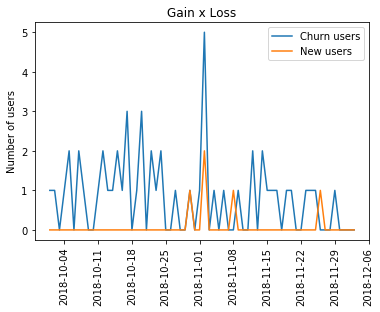

In [28]:
plt.plot(new_x_churn['day'], new_x_churn['churnUsers'], label = "Churn users")
plt.plot(new_x_churn['day'], new_x_churn['newUsers'], label = "New users")
plt.title('Gain x Loss')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [29]:
spark.sql('''
            SELECT DISTINCT level
            FROM clean_user_log_table
            '''
         ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



How are curves for active users in the app for free and paid ones by each day?

In [30]:
# Convert timestamp field in datetime
valid_log = valid_log.withColumn('occurred_at', from_unixtime((col('ts')/1000), 'yyyy-MM-dd HH:mm:ss'))
valid_log.createOrReplaceTempView('clean_user_log_table')

In [31]:
paid_users = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                COUNT(DISTINCT userID) AS paidUsers
            FROM clean_user_log_table
            WHERE level = "paid"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

free_users = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                COUNT(DISTINCT userID) AS freeUsers
            FROM clean_user_log_table
            WHERE level = "free"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

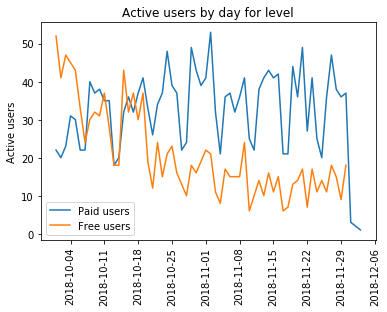

In [32]:
# plotting the curves for active users in the app for free and paid ones by each day
plt.plot(paid_users['day'], paid_users['paidUsers'], label = "Paid users")
plt.plot(free_users['day'], free_users['freeUsers'], label = "Free users")
plt.title('Active users by day for level')
plt.ylabel('Active users')
plt.xticks(rotation=90)
plt.legend()
plt.show()

The number of active free users declines over time in the app. Could these free users be becoming paid users?

In [33]:
upgrade_amt = spark.sql('''
            SELECT DATE_TRUNC('day', occurred_at) AS day,
                COUNT(DISTINCT userID) AS upgrade_amt
            FROM clean_user_log_table
            WHERE page = "Submit Upgrade"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

downgrade_amt = spark.sql('''
            SELECT DATE_TRUNC('day', occurred_at) AS day,
                COUNT(DISTINCT userID) AS downgrade_amt
            FROM clean_user_log_table
            WHERE page = "Submit Downgrade"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

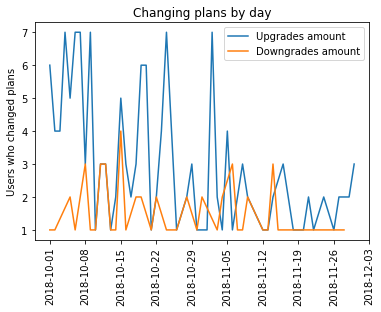

In [34]:
# plotting the curves for upgrade and downgrade plans by each day
plt.plot(upgrade_amt['day'], upgrade_amt['upgrade_amt'], label = "Upgrades amount")
plt.plot(downgrade_amt['day'], downgrade_amt['downgrade_amt'], label = "Downgrades amount")
plt.title('Changing plans by day')
plt.ylabel('Users who changed plans')
plt.xticks(rotation=90)
plt.legend()
plt.show()

The number of plans upgraded  by day is very expressive until near October 29, which explains the higher number of paid users compared to free ones close to this date and beyond. The number of upgrades is much higher than the downgrades, which is great too. Considering the two groups we have: users who canceled the streaming music service and users who stayed. How many of the users are free and paid by each of these groups?

In [35]:
level_churn = spark.sql('''
            SELECT DISTINCT(a.userID), b.lastAccess, a.level, c.isChurn
            FROM clean_user_log_table AS a
            RIGHT JOIN (
                SELECT userID,
                    MAX(occurred_at) lastAccess
                FROM clean_user_log_table
                GROUP BY 1
            ) AS b
            ON a.userID = b.userID AND a.occurred_at = b.lastAccess
            JOIN churn_user_table c
            ON c.userID = a.userID
            ORDER BY 1
            '''
         )

In [36]:
level_churn.toPandas().head(20)

,userID,lastAccess,level,isChurn
0,10,2018-11-19 12:49:48,paid,0
1,100,2018-11-30 14:15:49,paid,0
2,100001,2018-10-02 16:36:45,free,1
3,100002,2018-12-03 01:11:16,paid,0
4,100003,2018-10-11 16:19:41,free,1
5,100004,2018-11-29 02:37:45,paid,0
6,100005,2018-10-19 17:57:05,free,1
7,100006,2018-10-05 15:24:30,free,1
8,100007,2018-11-29 11:45:09,paid,1
9,100008,2018-11-27 16:13:39,free,0


In [37]:
# Counting how many users paid and free are in the two groups?
level_churn.createOrReplaceTempView('level_churn_table')
level_df = spark.sql('''
            SELECT isChurn, SUM(paid) AS paid, SUM(free) as free
            FROM (
                SELECT userID, isChurn,
                        (CASE WHEN level = "paid" THEN 1 ELSE 0 END) AS paid,                    
                        (CASE WHEN level = "free" THEN 1 ELSE 0 END) AS free
                FROM level_churn_table)
            GROUP BY 1
            '''
         ).toPandas()
level_df

,isChurn,paid,free
0,0,114,59
1,1,31,21


In [38]:
# Converting theses values in percentage
level_df.loc[0] = level_df.loc[0] * 100 / np.sum(level_df.loc[0])
level_df.loc[1] = level_df.loc[1] * 100 / np.sum(level_df.loc[1])
level_df.drop('isChurn', axis=1, inplace=True)
level_df.set_index(pd.Index(['Stayed', 'Churned']), inplace=True)
level_df

,paid,free
Stayed,65.895954,34.104046
Churned,58.490566,39.622642


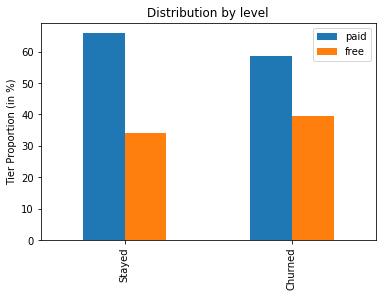

In [39]:
level_df[['paid', 'free']].plot(kind='bar', title='Distribution by level')
plt.ylabel('Tier Proportion (in %)');

We can see that free users are bit more susceptible to churn than paid users. Could the advertising average by session be related to it? First, let's use this feature in our data model! 

In [41]:
model_data = spark.sql('''
                            SELECT userID, level, isChurn
                            FROM level_churn_table
                        '''
                      )
model_data.createOrReplaceTempView('model_data')

In [42]:
spark.sql('''
            SELECT a.userID, a.advertising, b.level, b.isChurn
            FROM (
                SELECT userID,
                        SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising
                FROM clean_user_log_table
                GROUP BY 1
                ) AS a
            JOIN level_churn_table AS b
            ON a.userID = b.userID
            ORDER BY 4 DESC, 2 DESC
            '''
         ).toPandas().head(20)

,userID,advertising,level,isChurn
0,100022,115,free,1
1,100015,69,paid,1
2,200020,69,free,1
3,87,50,paid,1
4,54,47,paid,1
5,100009,42,free,1
6,100013,39,paid,1
7,100012,38,free,1
8,200018,32,free,1
9,100021,30,free,1


Since a user could downgrade or upgrade the service, the same user could have two phases in the log: the free and paid, whereas the “canceled confirmation” could happen in one of these phases. So, let’s separate the answer in these two phases: free and paid.

In [43]:
free_advertising = spark.sql('''
            SELECT userID, AVG(advertising) avgFreeAdvertising, 
                    MAX(lastSessionDate) lastFreeAccess, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                     SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising,
                     MAX(occurred_at) lastSessionDate,
                     SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                WHERE level = "free"
                GROUP BY 1, 2
                )
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            ''')

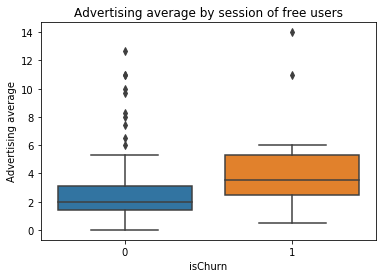

In [44]:
# visualize the distribution of advertising average by session of free users for both groups
sns.boxplot(y="avgFreeAdvertising", x="isChurn", data=free_advertising.toPandas())
plt.title('Advertising average by session of free users')
plt.ylabel('Advertising average')
plt.show()

In [45]:
paid_advertising = spark.sql('''
            SELECT userID, AVG(advertising) avgPaidAdvertising, 
                    MAX(lastSessionDate) lastPaidAccess, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                     SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising,
                     MAX(occurred_at) lastSessionDate,
                     SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                WHERE level = "paid"
                GROUP BY 1, 2
                )
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            ''')

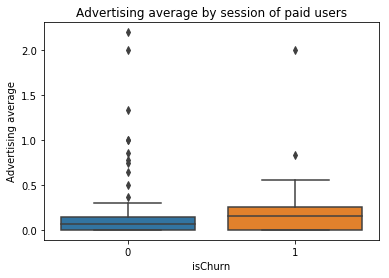

In [46]:
# visualize the distribution of advertising average by session of paid users for both groups
sns.boxplot(y="avgPaidAdvertising", x="isChurn", data=paid_advertising.toPandas())
plt.title('Advertising average by session of paid users')
plt.ylabel('Advertising average')
plt.show()

The distributions seem to be very different for both levels (paid and free), which could be a good indicator for our model. But before adding this measure to our model data, it’s necessary to treat it to get just the advertising for the last period level, i. e, if the user was free and upgraded to a paid account, we have to use the advertising average just for the paid period.

In [47]:
free_advertising.createOrReplaceTempView('free_advertising')
paid_advertising.createOrReplaceTempView('paid_advertising')
advertising = spark.sql('''
            SELECT 
                (CASE WHEN p.userID IS NOT NULL THEN p.userID ELSE f.userID END) AS userID, 
                (CASE WHEN lastPaidAccess IS NULL THEN avgFreeAdvertising
                    WHEN lastFreeAccess IS NULL THEN avgPaidAdvertising
                    WHEN lastPaidAccess > lastFreeAccess THEN avgPaidAdvertising 
                    ELSE avgFreeAdvertising END) AS advertising
            FROM paid_advertising AS p
            FULL OUTER JOIN free_advertising AS f
            ON p.userID = f.userID
            ORDER BY 1
            ''').toPandas()

In [48]:
model_data = model_data.toPandas()
model_data = model_data.set_index('userID')
advertising = model_data.join(advertising.set_index('userID'))

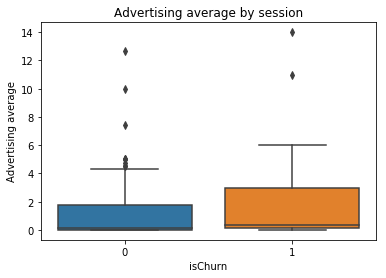

In [49]:
# visualize the distribution of advertising average by session of paid users for both groups
sns.boxplot(y="advertising", x="isChurn", data=advertising)
plt.title('Advertising average by session')
plt.ylabel('Advertising average')
plt.show()

Now with the advertising average isolated, it’s cleaner the effect of advertising on churned users. Let’s add this measure to our data model and find out if “Submit downgrade” could be either related to churn. 

In [50]:
model_data = advertising

In [51]:
downgrade = spark.sql('''
                SELECT userID,
                    CASE WHEN downgradeAmt > 0 THEN 1 ELSE 0 END AS isDowngraded,
                    isChurn
                FROM (
                    SELECT userID,
                         SUM(CASE WHEN page = "Submit Downgrade" THEN 1 ELSE 0 END) AS downgradeAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1
                )
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

In [52]:
values = [[downgrade.query('isDowngraded == 0 & isChurn == 0').shape[0],
           downgrade.query('isDowngraded == 0 & isChurn == 1').shape[0]],
          [downgrade.query('isDowngraded == 1 & isChurn == 0').shape[0],
           downgrade.query('isDowngraded == 1 & isChurn == 1').shape[0]]]
downgrade = pd.DataFrame(values, index=['Stayed', 'Churned'], columns=['Not Downgrade', 'Downgrade'])
downgrade

,Not Downgrade,Downgrade
Stayed,133,43
Churned,40,9


In [53]:
downgrade.loc['Stayed'] = downgrade.loc['Stayed'] * 100 / np.sum(downgrade.loc['Stayed'])
downgrade.loc['Churned'] = downgrade.loc['Churned'] * 100 / np.sum(downgrade.loc['Churned'])
downgrade

,Not Downgrade,Downgrade
Stayed,75.568182,24.431818
Churned,81.632653,18.367347


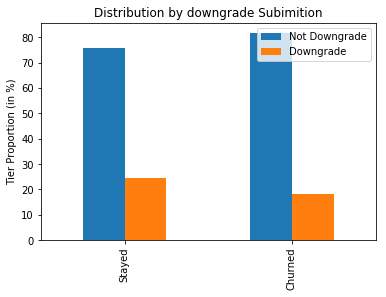

In [54]:
# visualize the distribution of downgrade page access average by session of paid users for both groups
downgrade[['Not Downgrade', 'Downgrade']].plot(kind='bar', title='Distribution by downgrade Subimition')
plt.ylabel('Tier Proportion (in %)');

The proportions for stayed and churned users are very close to who downgraded or not. So, this measure can't be a good indicator for our data model. Could the Thumbs up or Thumbs down action average by session be interpreted as a good indicator for our model?

In [55]:
thumbs_up = spark.sql('''
                SELECT userID, AVG(thumbsUpAmt) avgThumbsUp, SUM(isChurn) isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                GROUP BY 1
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

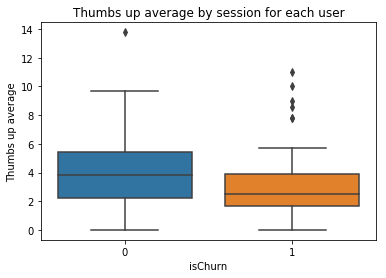

In [56]:
# visualize the distribution of thumbs up average by session for each user for both groups
sns.boxplot(y="avgThumbsUp", x="isChurn", data=thumbs_up)
plt.title('Thumbs up average by session for each user')
plt.ylabel('Thumbs up average')
plt.show()

The difference between the two distributions seems to strengthen the thumbs up average by session as a good indicator for our model. Let’s add this measure to our data model and find out if “Thumbs down” could be so good as “Thumbs up”.

In [57]:
model_data = model_data.join(thumbs_up[['userID', 'avgThumbsUp']].set_index('userID'))

In [58]:
thumbs_down = spark.sql('''
                SELECT userID, AVG(thumbsDownAmt) avgThumbsDown, SUM(isChurn) isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                GROUP BY 1
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

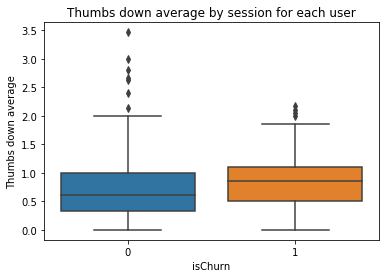

In [59]:
# visualize the distribution of thumbs down average by session for each user for both groups
sns.boxplot(y="avgThumbsDown", x="isChurn", data=thumbs_down)
plt.title('Thumbs down average by session for each user')
plt.ylabel('Thumbs down average')
plt.show()

We don’t have strong arguments to use these measures as indicators for our model. But if we assume that users who really like this streaming music service and his song recommendations, would accumulate a Thumbs up proportion much greater than Thumbs down. Wouldn't you think?

In [60]:
proportion_thumbsDown = spark.sql('''
                SELECT userID, (thumbsDownAmt / (thumbsUpAmt + thumbsDownAmt)) thumbsDownProportion, isChurn
                FROM (
                    SELECT userID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1
                    )
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

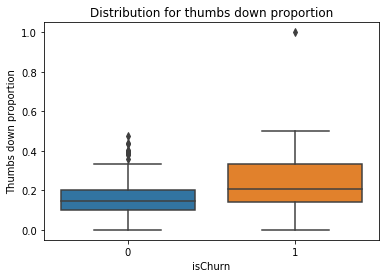

In [61]:
# visualize the distribution of thumbs down proportion by both groups
sns.boxplot(y="thumbsDownProportion", x="isChurn", data=proportion_thumbsDown)
plt.title('Distribution for thumbs down proportion')
plt.ylabel('Thumbs down proportion')
plt.show()

Thumbs down proportion plot shows us a huge difference between the two distributions, which could be favorable for our model. Let's analyze the average songs played per session.

In [62]:
model_data = model_data.join(proportion_thumbsDown[['userID', 'thumbsDownProportion']].set_index('userID'))

In [63]:
num_songs_by_session = spark.sql('''
            SELECT userID, AVG(numSongs) avgNumSongs, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                    SUM(CASE WHEN page = "NextSong" THEN 1 ELSE 0 END) AS numSongs,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2)
            GROUP BY 1
            ORDER BY 3, 2 DESC
            '''
         ).toPandas()

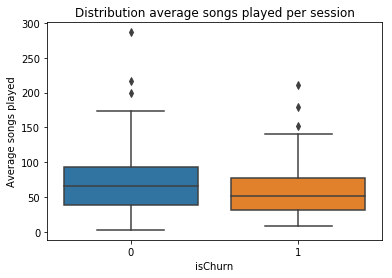

In [64]:
# visualize the distribution of average songs played per session by both groups
sns.boxplot(y="avgNumSongs", x="isChurn", data=num_songs_by_session)
plt.title('Distribution average songs played per session')
plt.ylabel('Average songs played')
plt.show()

In [65]:
model_data = model_data.join(num_songs_by_session[['userID', 'avgNumSongs']].set_index('userID'))

Could the average time spent per session for the users be a good indicator for our predictive model?

In [66]:
session_duration = spark.sql('''
            SELECT userID, avg(session_duration) avgSessionDuration, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID, MIN(occurred_at) initial_time, MAX(occurred_at) final_time,
                    (UNIX_TIMESTAMP(MAX(occurred_at)) - UNIX_TIMESTAMP(MIN(occurred_at))) session_duration,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2
                )
            GROUP BY 1
            ORDER BY 3, 2 DESC
            '''
         ).toPandas()

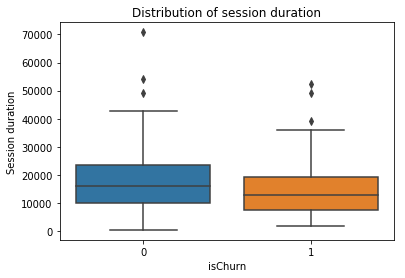

In [67]:
# visualize the distribution of session duration for both groups
sns.boxplot(y="avgSessionDuration", x="isChurn", data=session_duration)
plt.title('Distribution of session duration')
plt.ylabel('Session duration')
plt.show()

In [68]:
model_data = model_data.join(session_duration[['userID', 'avgSessionDuration']].set_index('userID'))

Could the number of songs added to playlist per session by the users be a good indicator for our predictive model?

In [69]:
num_playlist_addition_by_session = spark.sql('''
            SELECT userID, AVG(numPlaylistAddition) avgNumPlaylistAddition, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                    SUM(CASE WHEN page = "Add to Playlist" THEN 1 ELSE 0 END) AS numPlaylistAddition,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2)
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            '''
         ).toPandas()

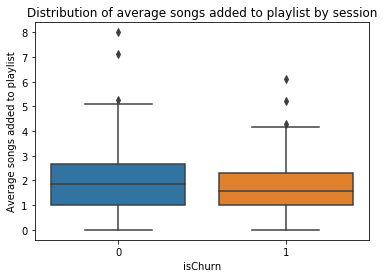

In [70]:
# visualize the distribution of average songs added to playlist per session by both groups
sns.boxplot(y="avgNumPlaylistAddition", x="isChurn", data=num_playlist_addition_by_session)
plt.title('Distribution of average songs added to playlist by session')
plt.ylabel('Average songs added to playlist')
plt.show()

In [71]:
model_data = model_data.join(num_playlist_addition_by_session[['userID', 'avgNumPlaylistAddition']].set_index('userID'))

Could the average friends added per session by the users be a good indicator for our predictive model?

In [72]:
num_friends_added_by_session = spark.sql('''
            SELECT userID, AVG(numFriendsAdded) avgNumFriendsAdded, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                    SUM(CASE WHEN page = "Add Friend" THEN 1 ELSE 0 END) AS numFriendsAdded,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2)
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            '''
         ).toPandas()

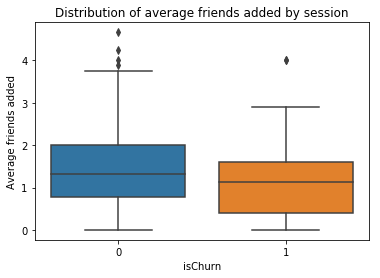

In [73]:
# visualize the distribution of average friends added per session by both groups
sns.boxplot(y="avgNumFriendsAdded", x="isChurn", data=num_friends_added_by_session)
plt.title('Distribution of average friends added by session')
plt.ylabel('Average friends added')
plt.show()

In [74]:
model_data = model_data.join(num_friends_added_by_session[['userID', 'avgNumFriendsAdded']].set_index('userID'))

Could the average time between two sessions be a good indicator for our predictive model?

In [135]:
session_duration = spark.sql('''
            SELECT userID, AVG(timeBetweenSessions) avgTimeBetweenSessions, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID, initial_time, final_time, isChurn,
                    UNIX_TIMESTAMP(LEAD(initial_time) OVER (PARTITION BY userID ORDER BY initial_time)) - UNIX_TIMESTAMP(final_time) AS timeBetweenSessions
                FROM (
                    SELECT userID, sessionID, MIN(occurred_at) initial_time, MAX(occurred_at) final_time,
                        SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                ORDER BY 1, 3
                )
            GROUP BY 1
            ORDER BY 3, 2 DESC
            '''
         ).toPandas()

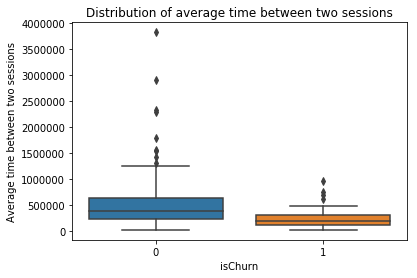

In [76]:
# visualize the distribution of average time between two sessions by both groups
sns.boxplot(y="avgTimeBetweenSessions", x="isChurn", data=session_duration)
plt.title('Distribution of average time between two sessions')
plt.ylabel('Average time between two sessions')
plt.show()

In [77]:
model_data = model_data.join(session_duration[['userID', 'avgTimeBetweenSessions']].set_index('userID'))

In [78]:
spark.sql('''
            SELECT DISTINCT(gender)
            FROM clean_user_log_table
            '''
         ).toPandas()

,gender
0,F
1,M


Could gender be a good indicator for our predictive model?

In [79]:
# Counting how many users paid and free are in the two groups?
genre_df = spark.sql('''
            SELECT isChurn, SUM(isMale) AS male, COUNT(*) - SUM(isMale) AS female
            FROM (
                SELECT userID,
                        CASE WHEN gender = "M" THEN 1 ELSE 0 END isMale,
                        SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2
            )
            GROUP BY 1
            '''
         ).toPandas()
genre_df

,isChurn,male,female
0,0,89,84
1,1,32,20


In [80]:
# Converting theses values in percentage
genre_df.loc[0] = genre_df.loc[0] * 100 / np.sum(genre_df.loc[0])
genre_df.loc[1] = genre_df.loc[1] * 100 / np.sum(genre_df.loc[1])
genre_df.drop('isChurn', axis=1, inplace=True)
genre_df.set_index(pd.Index(['Stayed', 'Canceled']), inplace=True)
genre_df

,male,female
Stayed,51.445087,48.554913
Canceled,60.377358,37.735849


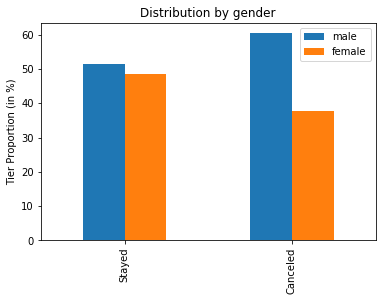

In [81]:
genre_df[['male', 'female']].plot(kind='bar', title='Distribution by gender')
plt.ylabel('Tier Proportion (in %)');

In [82]:
genre = spark.sql('''
                SELECT userID,
                        gender,
                        SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2
            '''
         ).toPandas()

In [83]:
model_data = model_data.join(genre[['userID', 'gender']].set_index('userID'))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [105]:
model_data.describe()

,isChurn,advertising,avgThumbsUp,thumbsDownProportion,avgNumSongs,avgSessionDuration,avgNumPlaylistAddition,avgNumFriendsAdded,avgTimeBetweenSessions
count,225.000000,225.000000,225.000000,221.000000,225.000000,225.000000,225.000000,225.000000,2.100000e+02
mean,0.231111,1.247396,3.735060,0.176896,69.002331,17289.959044,1.929065,1.373669,4.689066e+05
std,0.422483,2.114283,2.325835,0.121938,42.320954,10610.546683,1.277232,0.940729,4.678903e+05
min,0.000000,0.000000,0.000000,0.000000,3.000000,420.000000,0.000000,0.000000,2.871433e+04
25%,0.000000,0.000000,2.000000,0.105263,35.857143,9682.625000,1.000000,0.750000,2.054402e+05
50%,0.000000,0.166667,3.500000,0.156250,64.200000,15924.250000,1.800000,1.250000,3.190955e+05
75%,0.000000,2.000000,5.000000,0.215517,91.714286,22889.000000,2.617647,1.800000,5.976158e+05
max,1.000000,14.000000,13.777778,1.000000,286.666667,70794.000000,8.000000,4.666667,3.831080e+06


In [142]:
# Checking for nan values
model_data.isna().sum()

level                     0
isChurn                   0
advertising               0
avgThumbsUp               0
thumbsDownProportion      4
avgNumSongs               0
avgSessionDuration        0
avgNumPlaylistAddition    0
avgNumFriendsAdded        0
avgTimeBetweenSessions    0
gender                    0
dtype: int64

In [143]:
# Fill nan for 0, since: 
# 1. Who haven't time between session is a user who have just one session
# 2. Who haven't thumbs down proportion is because the user didn't gave any thumbs
model_data['avgTimeBetweenSessions'] = model_data['avgTimeBetweenSessions'].fillna(0)
model_data['thumbsDownProportion'] = model_data['thumbsDownProportion'].fillna(0)

In [144]:
model_df = spark.createDataFrame(model_data.values.tolist(), list(model_data.columns))
model_df.show()

+-----+-------+-------------------+------------------+--------------------+------------------+------------------+----------------------+------------------+----------------------+------+
|level|isChurn|        advertising|       avgThumbsUp|thumbsDownProportion|       avgNumSongs|avgSessionDuration|avgNumPlaylistAddition|avgNumFriendsAdded|avgTimeBetweenSessions|gender|
+-----+-------+-------------------+------------------+--------------------+------------------+------------------+----------------------+------------------+----------------------+------+
| paid|      0|0.16666666666666666| 6.166666666666667|  0.0975609756097561|112.16666666666667|27584.833333333332|                   1.5|               2.0|              700211.8|     M|
| paid|      0|0.13793103448275862| 4.228571428571429| 0.15428571428571428| 76.62857142857143| 18991.14285714286|    1.7428571428571429|               1.4|     130294.0294117647|     M|
| free|      1|                3.5|               2.0|                

In [149]:
from pyspark.ml import Pipeline

indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
vec_assembler = VectorAssembler(inputCols=['level_index', 
                                          'advertising', 
                                          'avgThumbsUp',
                                          'thumbsDownProportion', 
                                          'avgNumSongs', 
                                          'avgSessionDuration',
                                          'avgNumPlaylistAddition', 
                                          'avgNumFriendsAdded',
                                          'avgTimeBetweenSessions', 
                                          'gender_index'],
                           outputCol='features')

min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

pipeline = Pipeline(stages=[indexer_gender, indexer_level, vec_assembler, min_max_scaler])
model_fit = pipeline.fit(model_df).transform(model_df)

In [150]:
model_fit.head(2)

[Row(level='paid', isChurn=0, advertising=0.16666666666666666, avgThumbsUp=6.166666666666667, thumbsDownProportion=0.0975609756097561, avgNumSongs=112.16666666666667, avgSessionDuration=27584.833333333332, avgNumPlaylistAddition=1.5, avgNumFriendsAdded=2.0, avgTimeBetweenSessions=700211.8, gender='M', gender_index=0.0, level_index=0.0, features=DenseVector([0.0, 0.1667, 6.1667, 0.0976, 112.1667, 27584.8333, 1.5, 2.0, 700211.8, 0.0]), scaledFeatures=DenseVector([0.0, 0.0119, 0.4476, 0.0976, 0.3848, 0.386, 0.1875, 0.4286, 0.1828, 0.0])),
 Row(level='paid', isChurn=0, advertising=0.13793103448275862, avgThumbsUp=4.228571428571429, thumbsDownProportion=0.15428571428571428, avgNumSongs=76.62857142857143, avgSessionDuration=18991.14285714286, avgNumPlaylistAddition=1.7428571428571429, avgNumFriendsAdded=1.4, avgTimeBetweenSessions=130294.0294117647, gender='M', gender_index=0.0, level_index=0.0, features=DenseVector([0.0, 0.1379, 4.2286, 0.1543, 76.6286, 18991.1429, 1.7429, 1.4, 130294.0294,

In [153]:
data = model_fit.select("isChurn", "features")
data.head(2)

[Row(isChurn=0, features=DenseVector([0.0, 0.1667, 6.1667, 0.0976, 112.1667, 27584.8333, 1.5, 2.0, 700211.8, 0.0])),
 Row(isChurn=0, features=DenseVector([0.0, 0.1379, 4.2286, 0.1543, 76.6286, 18991.1429, 1.7429, 1.4, 130294.0294, 0.0]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
# Split this data between train, validation and test sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.